In [1]:
import pandas as pd
import os

# Utiliser le dossier courant comme base (par défaut dans les notebooks)
base_dir = os.getcwd()

# Chemins des sous-dossiers pour train et test
file_path = os.path.join(base_dir, r'data\donnees-historiques\prix\hourly_day_ahead_prices_2017_2020.parquet')

data1 = pd.read_parquet(file_path)

horizons = [6, 12, 24, 48, 72, 168]  # En heures





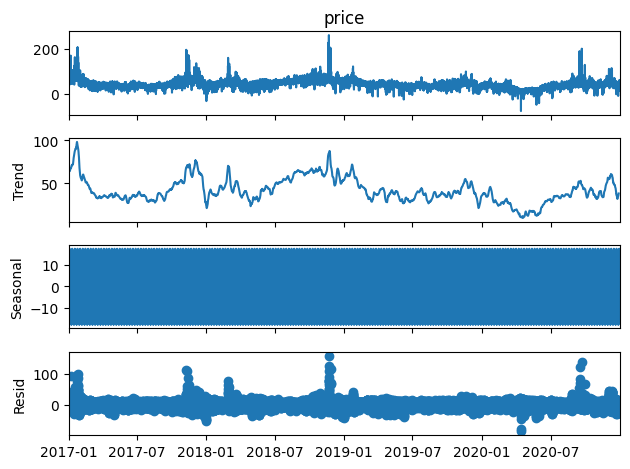

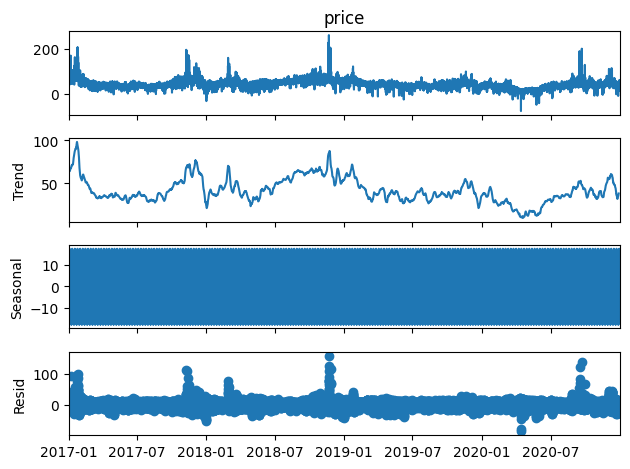

In [2]:
# Decomposition des séries temporelles
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data1['price'], model='additive', period=24*7)  # Période hebdomadaire
result.plot()


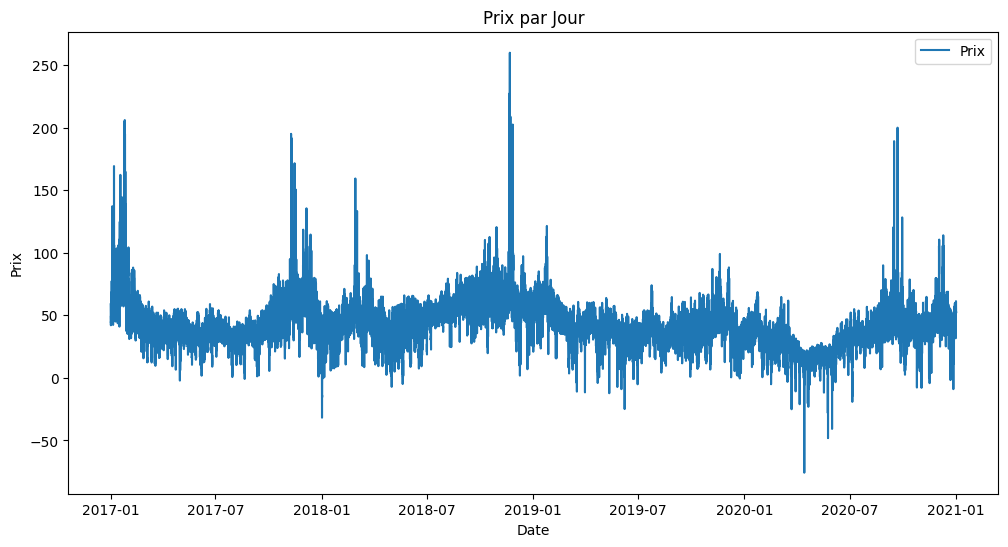

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data1.index, data1['price'], label='Prix')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.title('Prix par Jour')
plt.legend()
plt.show()

### creation des features temporelles

In [4]:
# Ajouter des features basées sur l'index temporel
data1['hour'] = data1.index.hour
data1['day_of_week'] = data1.index.dayofweek
data1['is_weekend'] = data1['day_of_week'] >= 5

# Ajouter des décalages temporels (lag features)
data1['price_lag_1'] = data1['price'].shift(1)  # Lag de 1
data1['price_lag_24'] = data1['price'].shift(24)  # Lag d'une journée (pour données horaires)

# Supprimer les lignes avec des NaN (causés par les lags)
data1.dropna(inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation des colonnes numériques
scaler = MinMaxScaler()
data1[['price_scaled', 'price_lag_1', 'price_lag_24']] = scaler.fit_transform(data1[['price', 'price_lag_1', 'price_lag_24']])

In [6]:
# Diviser les données en train et test
train = data1[:'2019']  # Données jusqu'à fin 2019
test = data1['2020':]  # Données à partir de 2020

# Vérifier les dimensions des ensembles
print(f"Train : {train.shape[0]} lignes")
print(f"Test : {test.shape[0]} lignes")


Train : 26257 lignes
Test : 8783 lignes


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Liste pour stocker les prédictions par horizon
# Liste pour stocker les prédictions
model_name='SARIMAX'
predictions = {}

# Ajout de tqdm pour suivre la progression
for horizon in tqdm(horizons, desc="Prédiction Multi-Horizons"):
    # Entraîner un modèle SARIMA pour chaque horizon
    model = SARIMAX(train['price'],
                    order=(1, 1, 1),  # ARIMA(p, d, q)
                    seasonal_order=(1, 1, 1, 24),  # Période saisonnière
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    sarima_model = model.fit(disp=False)

    # Faire des prédictions sur l'horizon défini
    forecast = sarima_model.forecast(steps=horizon)
    predictions[horizon] = forecast

Prédiction Multi-Horizons:   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\akues\OneDrive\Documents\GitHub\AugmentForecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\akues\OneDrive\Documents\GitHub\AugmentForecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
Prédiction Multi-Horizons:  17%|█▋        | 1/6 [01:18<06:31, 78.29s/it]c:\Users\akues\OneDrive\Documents\GitHub\AugmentForecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\akues\OneDrive\Documents\GitHub\AugmentForecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h wi

In [10]:
# Ajouter les données réelles pour chaque horizon
for horizon in horizons:
    test[f'price_horizon_{horizon}'] = test['price'].shift(-horizon)  # Décalage pour comparer

# Vérifier les données
print(test.head())


C:\Users\akues\AppData\Local\Temp\ipykernel_18000\4042875089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'price_horizon_{horizon}'] = test['price'].shift(-horizon)  # Décalage pour comparer
C:\Users\akues\AppData\Local\Temp\ipykernel_18000\4042875089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'price_horizon_{horizon}'] = test['price'].shift(-horizon)  # Décalage pour comparer
C:\Users\akues\AppData\Local\Temp\ipykernel_18000\4042875089.py:3: SettingWithCopyWarning: 
A value is t

                           price  hour  day_of_week  is_weekend  price_lag_1  \
date                                                                           
2020-01-01 00:00:00+00:00  38.60     0            2       False     0.350538   
2020-01-01 01:00:00+00:00  36.55     1            2       False     0.340769   
2020-01-01 02:00:00+00:00  32.32     2            2       False     0.334664   
2020-01-01 03:00:00+00:00  30.85     3            2       False     0.322066   
2020-01-01 04:00:00+00:00  30.14     4            2       False     0.317688   

                           price_lag_24  price_scaled  price_horizon_6  \
date                                                                     
2020-01-01 00:00:00+00:00      0.327724      0.340769            30.00   
2020-01-01 01:00:00+00:00      0.317986      0.334664            30.65   
2020-01-01 02:00:00+00:00      0.314561      0.322066            30.65   
2020-01-01 03:00:00+00:00      0.310957      0.317688            30.2

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialiser un dictionnaire pour stocker les métriques
metrics = {}

# Évaluer pour chaque horizon
# Ajuster la taille de actual et predicted pour chaque horizon
for horizon in horizons:
    # Données réelles ajustées pour correspondre à la longueur des prédictions
    actual = test[f'price_horizon_{horizon}'].iloc[:len(predictions[horizon])].dropna()

    # Prédictions pour l'horizon
    predicted = predictions[horizon]

    # Calculer les métriques uniquement sur les tailles correspondantes
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    # Stocker les métriques
    metrics[horizon] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Afficher les métriques
for horizon, metric in metrics.items():
    print(f"Horizon {horizon}h : MAE = {metric['MAE']:.2f}, RMSE = {metric['RMSE']:.2f}, MAPE = {metric['MAPE']:.2f}%")


Horizon 6h : MAE = 2.85, RMSE = 3.54, MAPE = 9.38%
Horizon 12h : MAE = 5.18, RMSE = 6.16, MAPE = 13.61%
Horizon 24h : MAE = 3.17, RMSE = 3.97, MAPE = 7.71%
Horizon 48h : MAE = 3.04, RMSE = 3.85, MAPE = 9.35%
Horizon 72h : MAE = 6.08, RMSE = 6.97, MAPE = 16.99%
Horizon 168h : MAE = 6.31, RMSE = 7.77, MAPE = 18.04%


In [28]:
# Stocker les métriques calculées dans un fichier JSON
import json 


metrics_file = "training_metrics_SARIMAX.json"

# Écrire les métriques dans un fichier JSON
with open(metrics_file, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Les métriques ont été enregistrées dans le fichier : {metrics_file}")

Les métriques ont été enregistrées dans le fichier : training_metrics_SARIMAX.json


: 

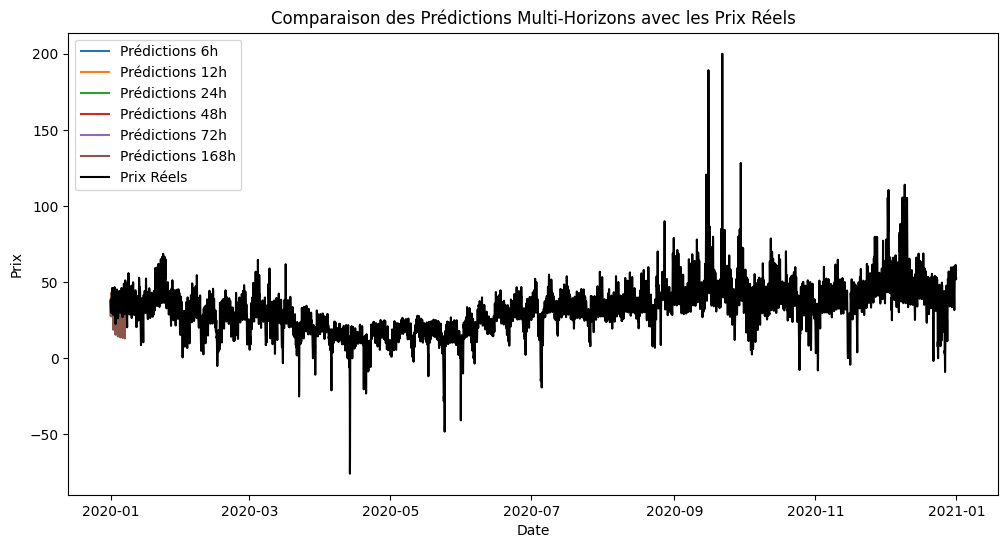

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Tracer les prédictions pour chaque horizon
for horizon in horizons:
    plt.plot(test.index[:len(predictions[horizon])], predictions[horizon], label=f'Prédictions {horizon}h')

# Tracer les données réelles
plt.plot(test.index, test['price'], label='Prix Réels', color='black')

plt.title('Comparaison des Prédictions Multi-Horizons avec les Prix Réels')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()


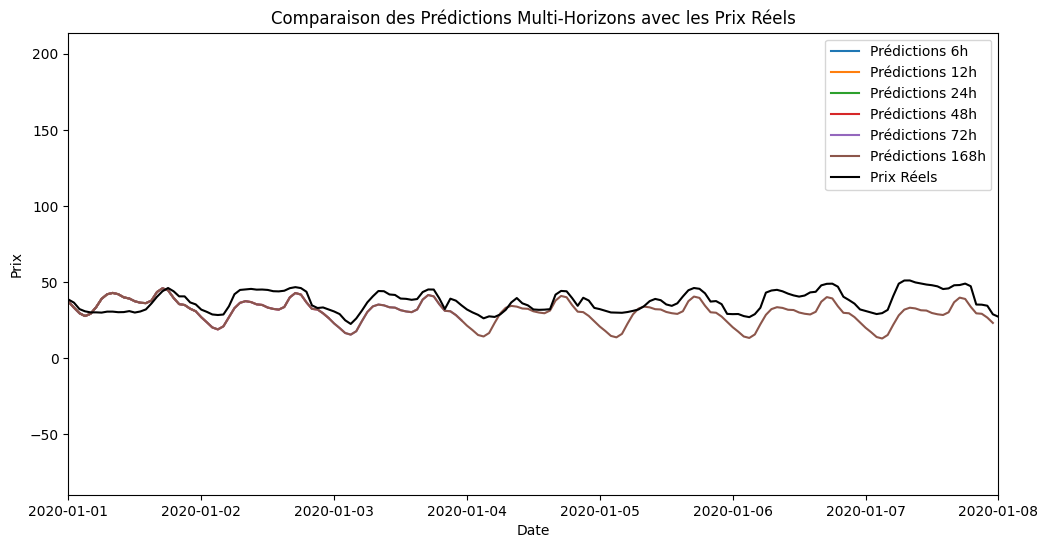

In [24]:
import matplotlib.pyplot as plt

# Visualiser les prédictions vs. les valeurs réelles
plt.figure(figsize=(12, 6))

for horizon in horizons:
    plt.plot(test.index[:len(predictions[horizon])], predictions[horizon], label=f'Prédictions {horizon}h')

# Tracer les données réelles
plt.plot(test.index, test['price'], label='Prix Réels', color='black')

plt.title('Comparaison des Prédictions Multi-Horizons avec les Prix Réels')
plt.xlim('2020-01-01', '2020-01-08')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()
